### Import statements

In [143]:
import sys
from sklearn import metrics
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib



params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20.0, 10.0),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':30,
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read inputs

In [144]:
#Load files
pdf = pd.read_csv("submission.csv")
tdf = pd.read_csv("test_private_expanded.csv")
#Get target and predicted
y_true = tdf.toxicity
y_pred = pdf.prediction
y_bin_true = (y_true >= .5) 
y_bin_pred = (y_pred >= .5) 

### Build logistic regression on data and our model prediction

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Text(0.5, 0, 'False positive rate (fpr)')

Text(0, 0.5, 'True positive rate (tpr)')

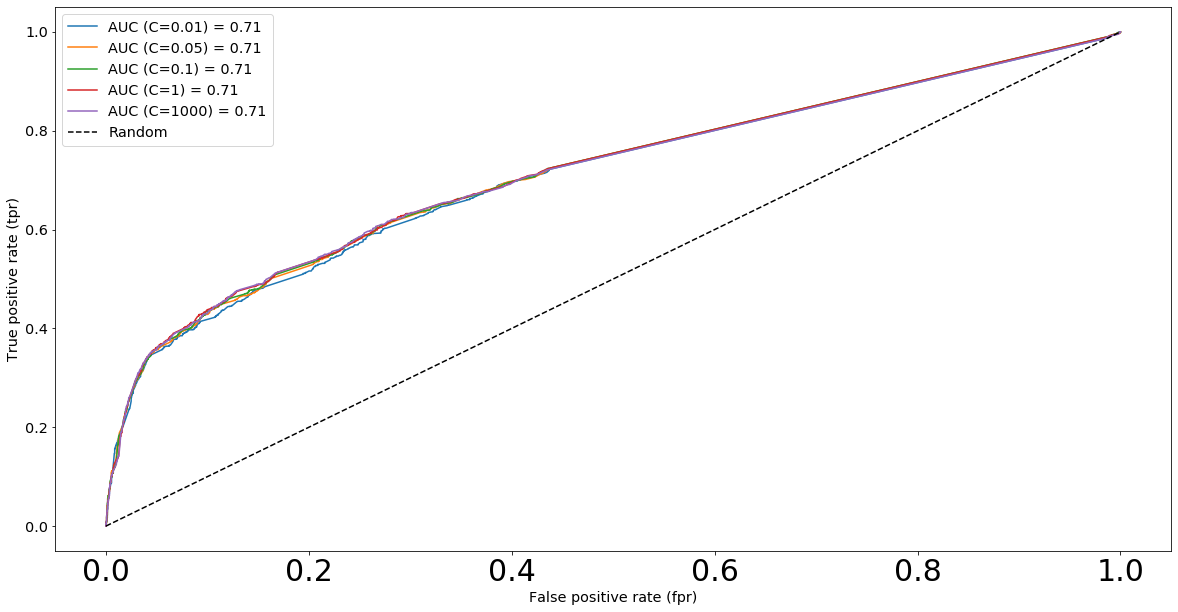

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

race_known = tdf.identity_annotator_count > 0
tdfn = tdf[race_known]
y_predn = y_bin_pred[race_known]
#Split train and test
X_train, X_test, Y_train, Y_test = train_test_split(tdfn.iloc[:,21:], y_predn, test_size=.2)

# Fit a logistic regression model
for c in [0.01, 0.05, .1, 1,1000]:
    model = LogisticRegression(C=c, solver='liblinear')
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X_train, Y_train, scoring="roc_auc", cv=5))

    # Plot the ROC curve
    plt.plot(fpr, tpr, label="AUC (C=" + str(c) + ") = " + str(round(auc, 2)))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

### Notice that the weights are disproportionally distributed

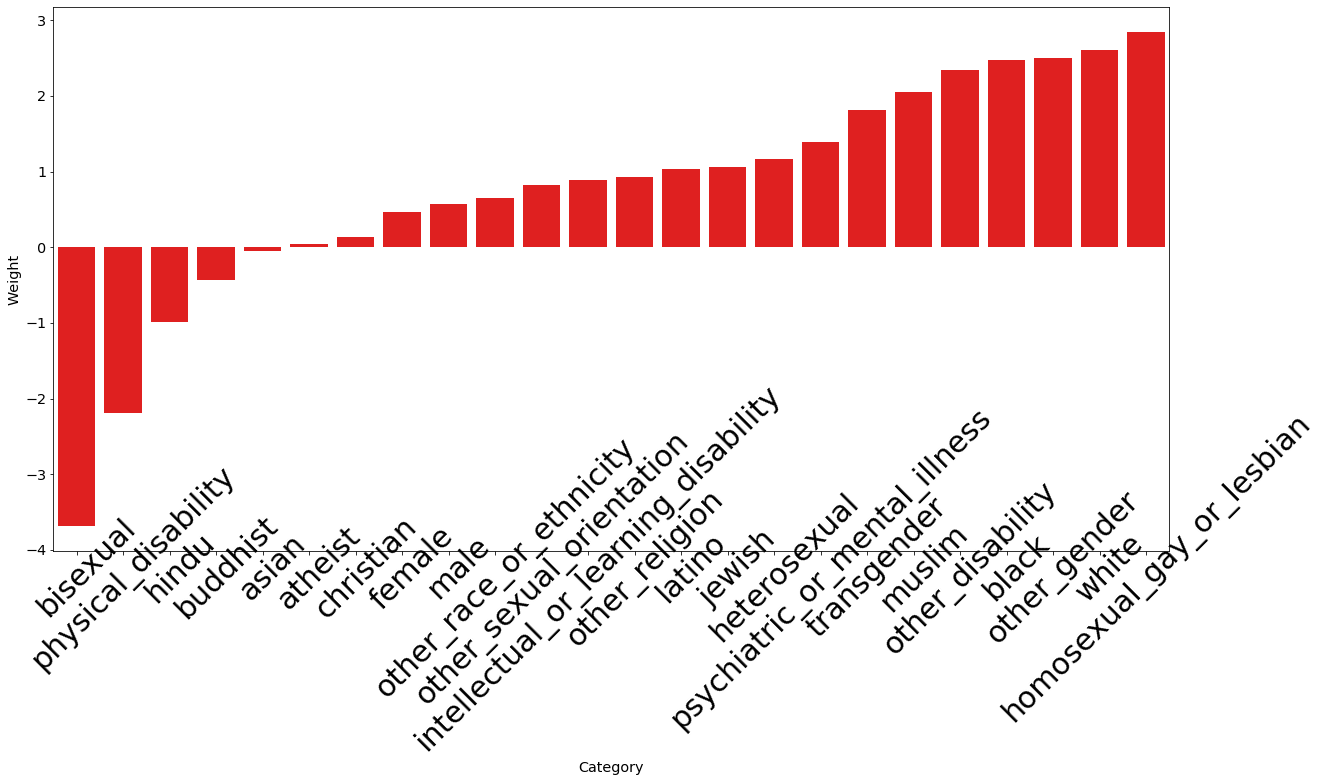

In [146]:
df = pd.DataFrame(zip(model.coef_[0], tdfn.iloc[:,21:].columns.values),columns = ["Weight","Category"])
#df.index = df["Category"]
df = df.sort_values(by="Weight")
#df = df.drop(["Category"],axis = 1)
ax = sns.barplot(x="Category",y="Weight",data=df,color="red",orient="v")
_ = ax.set_xticklabels(df.Category, rotation=45, rotation_mode="anchor")

In [147]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)



######
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
#####
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['toxicity'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df
#####
identity_columns = [
    'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability']

tdf["pred"] = pdf.prediction
bdf = convert_dataframe_to_bool(tdf)
bias_metrics_df = compute_bias_metrics_for_model(bdf, identity_columns, "pred", "toxicity")


### Look at the official competition bias metrics, both for toxicity and severe toxicity   

#### Regular toxicity

In [148]:
# Sort over regular toxicity

def select_sort(df,col,**kwargs):
    ndf = df.sort_values(by=col,**kwargs)
    return ndf[["subgroup","subgroup_size",col]]

bmetrics = {
    #"subgroup_size":"Size of the subgroup",
    "subgroup_auc":"A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.",
    "bpsn_auc":"A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.",
    "bnsp_auc":"A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity."
}

for metric in bmetrics:
    print("####")
    print(metric)
    print(bmetrics[metric])
    select_sort(bias_metrics_df,metric,ascending = True).head(10)
    print("####")

bias_metrics_df

####
subgroup_auc
A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.


subgroup  subgroup_size  subgroup_auc
4                heterosexual             66      0.859216
5   homosexual_gay_or_lesbian            538      0.859595
15                      black            761      0.870321
16                      white           1178      0.876182
10                     muslim           1054      0.879888
12                   buddhist             27      0.880435
2                 transgender            129      0.902166
17                      asian            217      0.913022
9                      jewish            411      0.914980
13                    atheist            149      0.916547

####
####
bpsn_auc
A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.


subgroup  subgroup_size  bpsn_auc
4                heterosexual             66  0.897242
15                      black            761  0.903006
16                      white           1178  0.903431
5   homosexual_gay_or_lesbian            538  0.910076
2                 transgender            129  0.924760
10                     muslim           1054  0.926397
18                     latino            121  0.933609
14             other_religion             15  0.938556
9                      jewish            411  0.942269
19    other_race_or_ethnicity             16  0.949633

####
####
bnsp_auc
A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.


subgroup  subgroup_size  bnsp_auc
12                   buddhist             27  0.921621
14             other_religion             15  0.928403
13                    atheist            149  0.939762
17                      asian            217  0.951700
8                   christian           2109  0.962267
6                    bisexual             21  0.963850
11                      hindu             28  0.964010
10                     muslim           1054  0.964278
5   homosexual_gay_or_lesbian            538  0.965246
1                      female           2602  0.965853

####


subgroup  subgroup_size  subgroup_auc  \
4                          heterosexual             66      0.859216   
5             homosexual_gay_or_lesbian            538      0.859595   
15                                black            761      0.870321   
16                                white           1178      0.876182   
10                               muslim           1054      0.879888   
12                             buddhist             27      0.880435   
2                           transgender            129      0.902166   
17                                asian            217      0.913022   
9                                jewish            411      0.914980   
13                              atheist            149      0.916547   
14                       other_religion             15      0.928571   
18                               latino            121      0.940092   
0                                  male           2112      0.941734   
1                                female           2602      0.947105   
8                             christian           2109      0.950127   
6                              bisexual             21      0.962963   
22        psychiatric_or_mental_illness            238      0.963667   
11                                hindu             28      0.979167   
19              other_race_or_ethnicity             16      1.000000   
21  intellectual_or_learning_disability             14      1.000000   
3                          other_gender              0           NaN   
7              other_sexual_orientation              1           NaN   
20                  physical_disability              3           NaN   
23                     other_disability              0           NaN   

    bpsn_auc  bnsp_auc  
4   0.897242  0.969293  
5   0.910076  0.965246  
15  0.903006  0.970789  
16  0.903431  0.972399  
10  0.926397  0.964278  
12  0.969448  0.921621  
2   0.924760  0.970291  
17  0.961650  0.951700  
9   0.942269  0.965954  
13  0.971227  0.939762  
14  0.938556  0.928403  
18  0.933609  0.978249  
0   0.953762  0.971634  
1   0.965635  0.965853  
8   0.969886  0.962267  
6   0.966569  0.963850  
22  0.951114  0.982374  
11  0.973761  0.964010  
19  0.949633  0.987608  
21  0.993867  0.991321  
3        NaN       NaN  
7   0.973254       NaN  
20  0.999014       NaN  
23       NaN       NaN

#### Severe

In [149]:
sbdf = bdf.copy()
sbdf["severe_toxicity"] = sbdf["severe_toxicity"] > 0
bias_metrics_df = compute_bias_metrics_for_model(sbdf, identity_columns, "pred", "severe_toxicity")

for metric in bmetrics:
    print("####")
    print(metric)
    print(bmetrics[metric])
    select_sort(bias_metrics_df,metric,ascending = True).head(10)
    print("####")



####
subgroup_auc
A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.


subgroup  subgroup_size  subgroup_auc
11                      hindu             28      0.557692
12                   buddhist             27      0.600000
5   homosexual_gay_or_lesbian            538      0.786395
4                heterosexual             66      0.791071
2                 transgender            129      0.795168
18                     latino            121      0.800000
15                      black            761      0.812172
16                      white           1178      0.819073
9                      jewish            411      0.837074
10                     muslim           1054      0.847773

####
####
bpsn_auc
A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.


subgroup  subgroup_size  bpsn_auc
15                      black            761  0.758740
4                heterosexual             66  0.760800
16                      white           1178  0.762853
5   homosexual_gay_or_lesbian            538  0.766908
19    other_race_or_ethnicity             16  0.770192
2                 transgender            129  0.788177
10                     muslim           1054  0.794469
18                     latino            121  0.802001
6                    bisexual             21  0.824129
9                      jewish            411  0.827531

####
####
bnsp_auc
A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.


subgroup  subgroup_size  bnsp_auc
11                          hindu             28  0.754473
12                       buddhist             27  0.760495
8                       christian           2109  0.899123
13                        atheist            149  0.907331
17                          asian            217  0.918084
1                          female           2602  0.923670
9                          jewish            411  0.927052
18                         latino            121  0.932913
2                     transgender            129  0.934172
22  psychiatric_or_mental_illness            238  0.936369

####


# The Ingredients

In [157]:
from sklearn.metrics import confusion_matrix
tdfn["bin_toxicity"] = tdfn.toxicity >= .5
tdfn["predicted_toxicity"] = y_predn >=.5
mention_threshold = .1

#mentions
mentions = (tdfn.iloc[:,-26:] > mention_threshold).sum()
mentioned_toxic_comments = (tdfn.loc[tdfn.bin_toxicity].iloc[:,-26:] > mention_threshold).sum()
mentioned_non_toxic_comments = (tdfn.loc[~tdfn.bin_toxicity].iloc[:,-26:] > mention_threshold).sum()
df = pd.concat([mentions,mentioned_toxic_comments,mentioned_non_toxic_comments],axis = 1)
df.columns = ["mentions","mentioned_toxic_comments","mentioned_non_toxic_comments"]
df["not_mentioned"] = tdfn.shape[0] - mentions
df

/Users/benwolfson/anaconda3/envs/data_resp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/benwolfson/anaconda3/envs/data_resp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


mentions  mentioned_toxic_comments  \
male                                     3511                       523   
female                                   3454                       485   
transgender                               233                        38   
other_gender                               61                         9   
heterosexual                              118                        19   
homosexual_gay_or_lesbian                 679                       179   
bisexual                                  123                        16   
other_sexual_orientation                   95                        15   
christian                                3136                       293   
jewish                                    504                        79   
muslim                                   1287                       273   
hindu                                      55                         8   
buddhist                                   49                         7   
atheist                                   169                        11   
other_religion                            423                        53   
black                                     931                       279   
white                                    1362                       374   
asian                                     476                        54   
latino                                    310                        56   
other_race_or_ethnicity                   592                        77   
physical_disability                        86                         9   
intellectual_or_learning_disability        84                        17   
psychiatric_or_mental_illness             477                       101   
other_disability                           97                        12   
bin_toxicity                             2399                      2399   
predicted_toxicity                       7001                      2346   

                                     mentioned_non_toxic_comments  \
male                                                         2988   
female                                                       2969   
transgender                                                   195   
other_gender                                                   52   
heterosexual                                                   99   
homosexual_gay_or_lesbian                                     500   
bisexual                                                      107   
other_sexual_orientation                                       80   
christian                                                    2843   
jewish                                                        425   
muslim                                                       1014   
hindu                                                          47   
buddhist                                                       42   
atheist                                                       158   
other_religion                                                370   
black                                                         652   
white                                                         988   
asian                                                         422   
latino                                                        254   
other_race_or_ethnicity                                       515   
physical_disability                                            77   
intellectual_or_learning_disability                            67   
psychiatric_or_mental_illness                                 376   
other_disability                                               85   
bin_toxicity                                                    0   
predicted_toxicity                                           4655   

                                     not_mentioned  
male                                         18066  
female                                   

## The Results

In [138]:
d = {}
for i in tdfn.columns[-26:-2]:
    subset_df = tdfn[tdfn[i] > mention_threshold]
    cm = confusion_matrix(subset_df["bin_toxicity"],subset_df["predicted_toxicity"])
    tn, fp, fn, tp = cm.ravel()
    d[i] = (tn, fp, fn, tp)
    
    
cmdf = pd.DataFrame.from_dict(d).T
cmdf.columns = ["TN","FP","FN","TP"] 
sdf = df.merge(cmdf,right_index=True,left_index=True)
sdf["TPR"] = sdf["TP"]/(sdf["TP"]+sdf["FN"])
sdf["FPR"] = sdf["FP"]/(sdf["TN"]+sdf["FP"])
sdf["TNR"] = 1-sdf["FPR"]
sdf["FNR"] = 1-sdf["TPR"]
sdf

mentions  mentioned_toxic_comments  \
male                                     3511                       523   
female                                   3454                       485   
transgender                               233                        38   
other_gender                               61                         9   
heterosexual                              118                        19   
homosexual_gay_or_lesbian                 679                       179   
bisexual                                  123                        16   
other_sexual_orientation                   95                        15   
christian                                3136                       293   
jewish                                    504                        79   
muslim                                   1287                       273   
hindu                                      55                         8   
buddhist                                   49                         7   
atheist                                   169                        11   
other_religion                            423                        53   
black                                     931                       279   
white                                    1362                       374   
asian                                     476                        54   
latino                                    310                        56   
other_race_or_ethnicity                   592                        77   
physical_disability                        86                         9   
intellectual_or_learning_disability        84                        17   
psychiatric_or_mental_illness             477                       101   
other_disability                           97                        12   

                                     mentioned_non_toxic_comments  \
male                                                         2988   
female                                                       2969   
transgender                                                   195   
other_gender                                                   52   
heterosexual                                                   99   
homosexual_gay_or_lesbian                                     500   
bisexual                                                      107   
other_sexual_orientation                                       80   
christian                                                    2843   
jewish                                                        425   
muslim                                                       1014   
hindu                                                          47   
buddhist                                                       42   
atheist                                                       158   
other_religion                                                370   
black                                                         652   
white                                                         988   
asian                                                         422   
latino                                                        254   
other_race_or_ethnicity                                       515   
physical_disability                                            77   
intellectual_or_learning_disability                            67   
psychiatric_or_mental_illness                                 376   
other_disability                                               85   

                                     not_mentioned    TN   FP  FN   TP  \
male                                         18066  1999  989  12  511   
female                                       18123  2072  897  13  472   
transgender                                  21344   102   93   0   38   
other_gender                                 21516    35   17   0    9   
heterosexual                                 21459    43   56   2

In [139]:
sdf["nationality"] = sdf.index

Text(0.5, 1.0, 'FPR')

(0, 1)

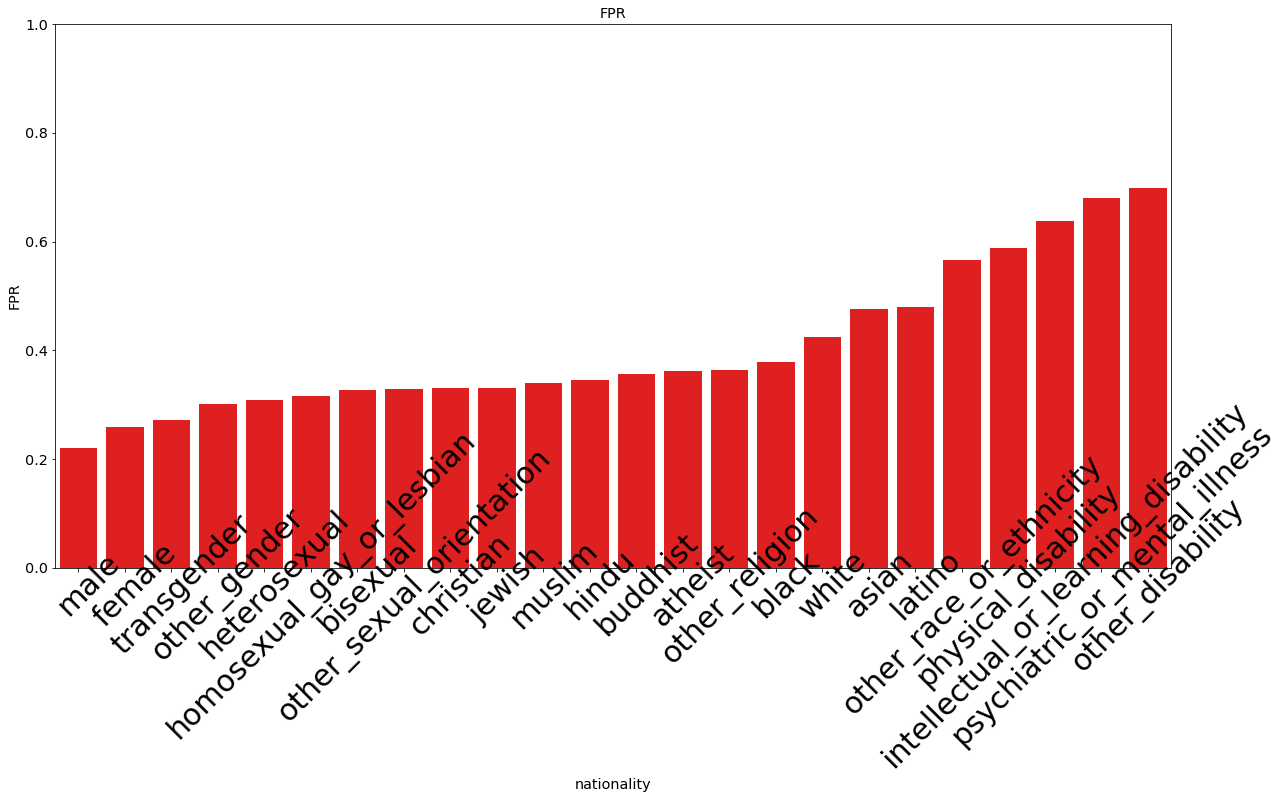

Text(0.5, 1.0, 'TPR')

(0, 1)

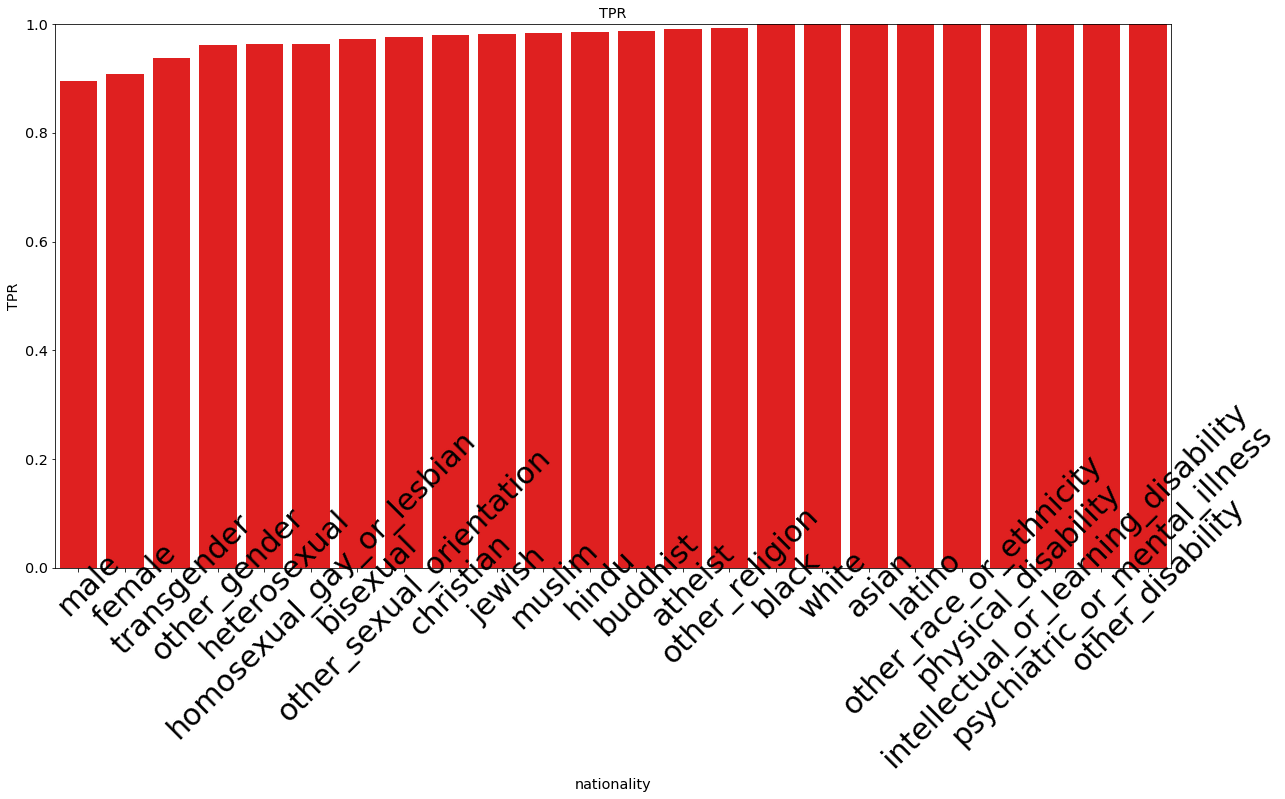

Text(0.5, 1.0, 'FNR')

(0, 1)

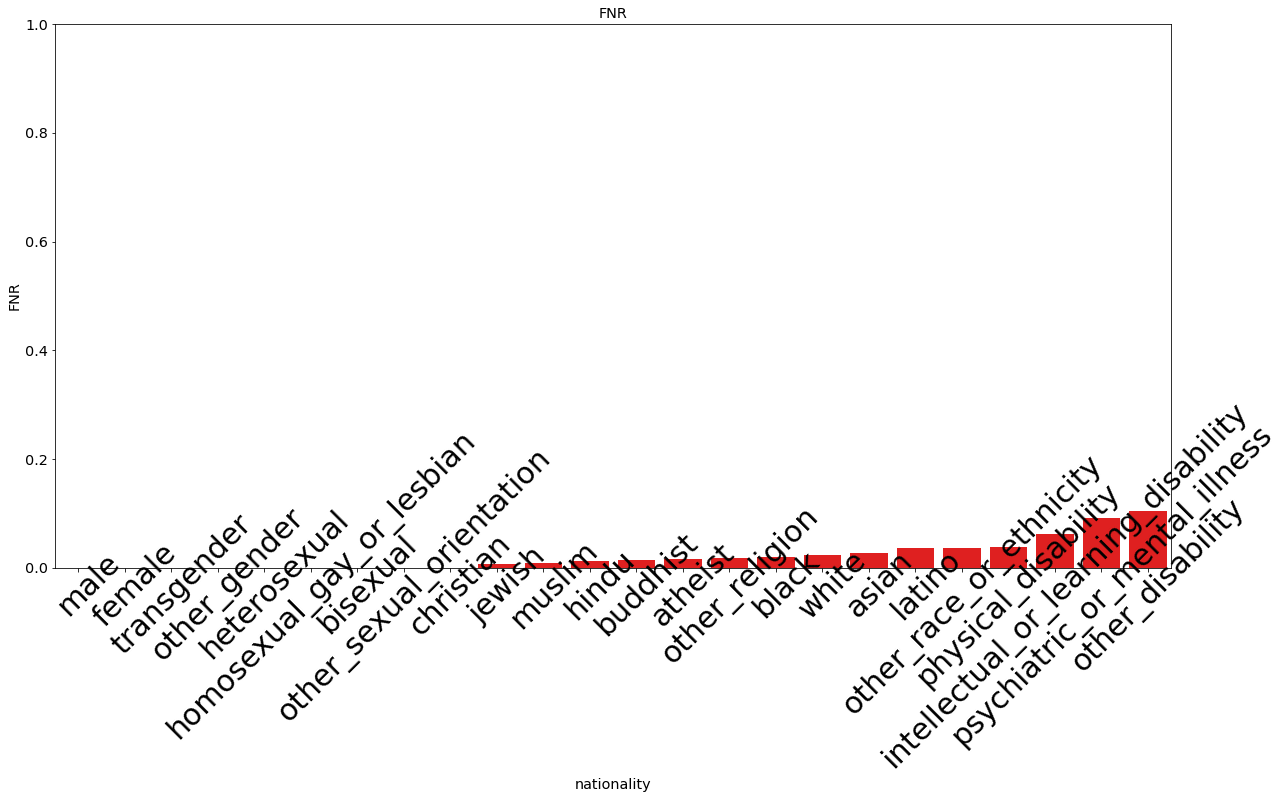

Text(0.5, 1.0, 'TNR')

(0, 1)

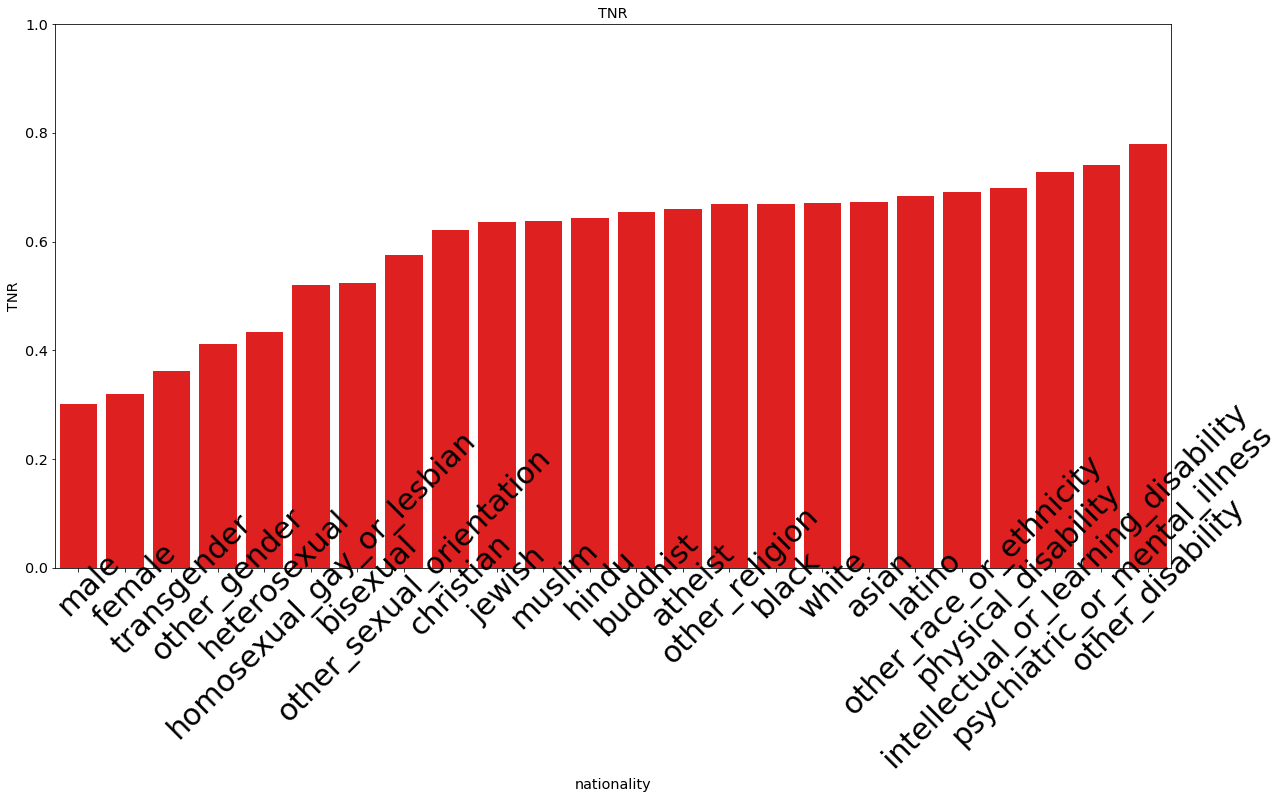

In [137]:
#The classifier is really good at not tagging non-toxic comments as toxic
#It tags a significant nmber of non-toxic comments as toxic
for i in ["FPR","TPR","FNR","TNR"]:
    ax = sns.barplot(x="nationality",y=i,data=sdf.sort_values(i),color="red",orient="v")
    _ = ax.set_xticklabels(sdf.nationality, rotation=45, rotation_mode="anchor")
    ax.set_title(i)
    ax.set_ylim((0,1))
    plt.show()

# Let's look at some words

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [154]:
text_mat = vectorizer.fit_transform(tdfn.comment_text)

In [155]:
lr = LogisticRegression()

In [158]:
clf = lr.fit(text_mat,tdfn.predicted_toxicity)

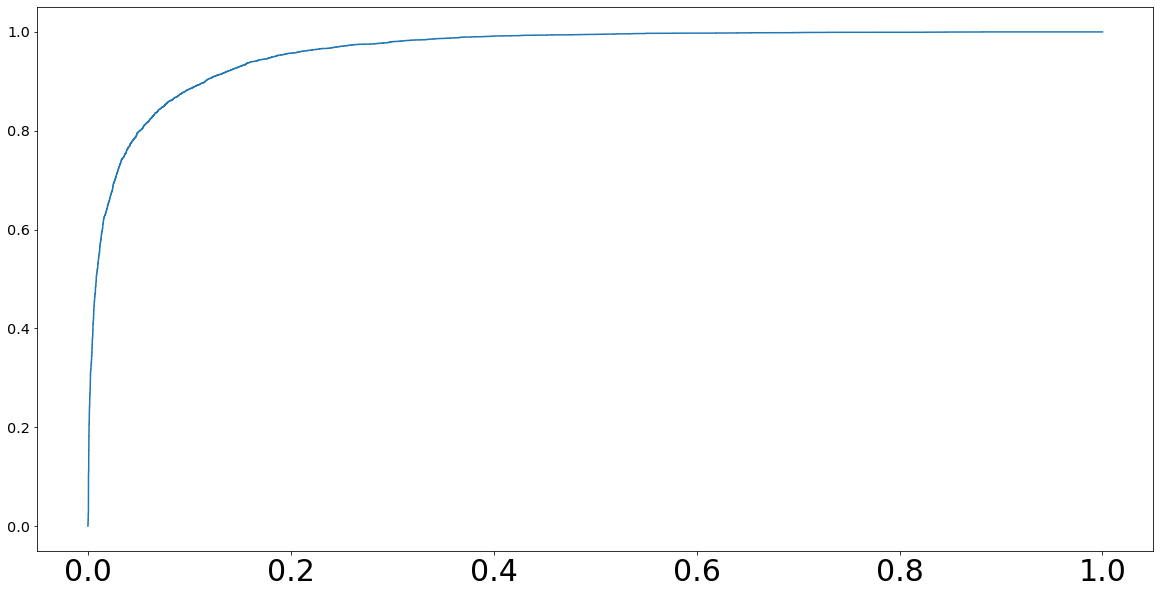

In [160]:
model=clf
Y_test = tdfn.predicted_toxicity
# Get the probability of Y_test records being = 1
Y_test_probability_1 = lr.predict_proba(text_mat)[:, 1]

# Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)

# Plot the ROC curve
plt.plot(fpr, tpr)

In [178]:
#tdfn["clf_pred"]=
clf_pred = c.predict(tdfn.comment_text)


id                                       comment_text  \
1      7097321  This is malfeasance by the Administrator and t...   
2      7097322  @Rmiller101 - Spoken like a true elitist. But ...   
15     7097335  IT IS DOA! As Collins announced her intentions...   
21     7097341  It's a black mark on the previous administrati...   
37     7097357  Don’t get it do you. As the price of things go...   
...        ...                                                ...   
97296  7194616  I agree whole-heartedly with your Rick Lewis c...   
97301  7194621  Women not shopping for a day to protest what??...   
97308  7194628  1. You know no more than I do. It's a logical ...   
97309  7194629  As the man said... you can teach a person how ...   
97311  7194631  Let's look at it another way: as society begin...   

                        created_date  publication_id  parent_id  article_id  \
1      2017-05-17 07:01:51.902566+00              55        NaN      335003   
2      2016-12-02 17:12:12.920957+00              54   649389.0      154126   
15     2017-09-26 00:36:00.063263+00              21        NaN      381593   
21     2017-02-21 13:29:03.585950+00              54  1023688.0      169431   
37     2017-08-01 19:59:42.013163+00              54  5696163.0      361623   
...                              ...             ...        ...         ...   
97296  2017-07-26 17:58:47.482867+00             102  5661622.0      359476   
97301  2017-03-09 00:37:53.797292+00              55        NaN      317840   
97308  2017-10-27 15:03:29.398300+00              13  6232878.0      392047   
97309  2016-07-18 06:57:57.120341+00              21   390819.0      141602   
97311  2017-09-19 13:09:49.575004+00              54        NaN      379397   

         rating  funny  wow  sad  ...  white  asian  latino  \
1      approved      0    0    0  ...    0.0    0.0     0.0   
2      approved      0    0    0  ...    0.0    0.0     0.0   
15     approved      0    0    0  ...    0.0    0.0     0.0   
21     approved      0    0    0  ...    0.0    0.0     0.0   
37     approved      0    0    0  ...    0.0    0.0     0.0   
...         ...    ...  ...  ...  ...    ...    ...     ...   
97296  approved      1    0    0  ...    0.0    0.0     0.0   
97301  approved      0    0    0  ...    0.0    0.0     0.0   
97308  approved      0    0    0  ...    0.0    0.0     0.0   
97309  rejected      0    0    0  ...    0.0    0.0     0.0   
97311  approved      0    0    0  ...    0.0    0.0     0.0   

       other_race_or_ethnicity  physical_disability  \
1                          0.0                  0.0   
2                          0.0                  0.0   
15                         0.0                  0.0   
21                         0.0                  0.0   
37                         0.0                  0.0   
...                        ...                  ...   
97296                      0.0                  0.0   
97301                      0.0                  0.0   
97308                      0.0                  0.0   
97309                      0.0                  0.0   
97311                      0.0                  0.0   

       intellectual_or_learning_disability  psychiatric_or_mental_illness  \
1                                      0.0                            0.0   
2                                      0.0                            0.0   
15                                     0.0                            0.0   
21                                     0.0                            0.0   
37                                     0.0                            0.0   
...                                    ...                            ...   
97296                                  0.0                            0.0   
97301                                  0.0                            0.0   
97308                                  0.0                            0.0   
97309                                  0.0    

In [182]:
tdfn["clf_pred"] = clf_pred

4683

In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
#sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')


def get_incorrectly_tagged_indices(df,subgroup,mention_threshold,incorrect_tag):
    df_sub = df[df[subgroup] > mention_threshold]
    df_sub = df_sub[df_sub["bin_toxicity"] == incorrect_tag]
    df_sub_clf = df_sub[df_sub["predicted_toxicity"] == df_sub["clf_pred"]]
    
    return df_sub_clf[df_sub_clf["bin_toxicity"] != df_sub_clf["predicted_toxicity"]].index.values



def interpret_data(func,test_set,target, class_names,indices=range(5),file_prefix="part_b_i"):
    explainer = LimeTextExplainer(class_names=class_names)
    scores = []
    for r_idx in indices:
        exp = explainer.explain_instance(test_set[r_idx], func, num_features=6)
        %matplotlib inline
        fig = exp.as_pyplot_figure()
        if target[r_idx] == 1:
            tclass = "Toxic"
        else:
            tclass = "Non-Toxic"
        print(F"the correct classification is {tclass}")
        exp.show_in_notebook()
        #exp.save_to_file(f"{file_prefix}_{r_idx}.html")
        scores.append(exp.score)

    return scores


def get_incorrect_examples(tdfn,identity,mention_threshold,toxicity):
    get_incorrect_examples.c = make_pipeline(vectorizer, clf)
    indices =get_incorrectly_tagged_indices(tdfn,identity,mention_threshold,toxicity)
    interpret_data(get_incorrect_examples.c.predict_proba, tdfn.comment_text,tdfn["bin_toxicity"],['non_toxic','toxic'],indices = indices[0:5])

get_incorrect_examples(tdfn,'christian',mention_threshold,0)

#interpret_data(c.predict_proba, tdfn.comment_text,tdfn["bin_toxicity"],['toxic','non_toxic'],indices = [1,2])


the correct classification is Non-Toxic


the correct classification is Non-Toxic


the correct classification is Non-Toxic


the correct classification is Non-Toxic


the correct classification is Non-Toxic


[0.8251636197383105,
 0.9226112966929698,
 0.8442449377636515,
 0.9322876012796046,
 0.9163110076407424]

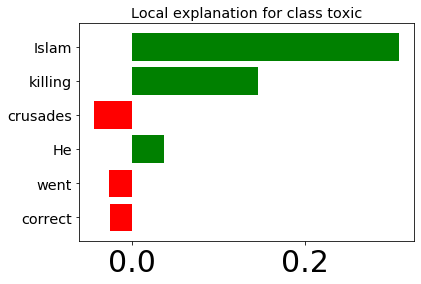

In [205]:
# df_sub = tdfn[tdfn['christian'] > mention_threshold]
# df_sub = df_sub[df_sub["bin_toxicity"] == 1]
# df_sub_clf = df_sub[df_sub["predicted_toxicity"] == df_sub["clf_pred"]]
# df_sub_clf[df_sub_clf["bin_toxicity"] != df_sub_clf["predicted_toxicity"]]
# tdfn.loc[14665]

id                                       comment_text  \
14665  7111985  In lifeofthedelayed's mind, the church can do ...   
16593  7113913  "The pope issues an encyclical, the only one h...   
18282  7115602  Wow, Mike - you really ticked off some atheist...   
31277  7128597  They'd be singing a different tune if the bake...   
31578  7128898  I never said that women priests meant there sh...   
32876  7130196  Jenifer; What those in the Hierarchy fail to u...   
44942  7142262  If one of these Priests were in my Parish, mos...   
49994  7147314  It will be interesting to see if the latest re...   
52091  7149411  I have 2 volumes of the "lost books" and heck ...   
70615  7167935  I generally agree with the article but want to...   

                        created_date  publication_id  parent_id  article_id  \
14665  2017-04-04 13:31:53.298150+00              53  5089396.0      324243   
16593  2016-11-16 17:46:21.664823+00              53        NaN      151879   
18282  2016-04-13 14:40:03.062426+00              13   279491.0       59080   
31277  2017-09-08 03:44:42.369787+00             102  5918385.0      375328   
31578  2017-01-03 20:06:15.505161+00              53   783579.0      159299   
32876  2017-04-05 16:50:33.686485+00              53  5088685.0      324243   
44942  2017-02-03 19:35:54.244789+00              53        NaN      165736   
49994  2017-08-21 14:30:15.472052+00              53        NaN      368840   
52091  2016-03-28 17:24:49.889150+00              13   261371.0       54157   
70615  2017-03-03 22:45:44.405940+00              54        NaN      316502   

         rating  funny  wow  sad  ...  asian    latino  \
14665  approved      1    0    0  ...    0.0  0.000000   
16593  approved      0    0    0  ...    0.0  0.000000   
18282  approved      0    0    0  ...    0.0  0.000000   
31277  approved      1    0    0  ...    0.0  0.000000   
31578  approved      0    0    0  ...    0.0  0.000000   
32876  approved      0    0    0  ...    0.0  0.000000   
44942  approved      0    0    0  ...    0.0  0.000000   
49994  approved      0    0    0  ...    0.0  0.000000   
52091  approved      0    0    0  ...    0.0  0.000000   
70615  approved      0    0    0  ...    0.0  0.166667   

       other_race_or_ethnicity  physical_disability  \
14665                      0.0                  0.0   
16593                      0.0                  0.0   
18282                      0.0                  0.0   
31277                      0.0                  0.0   
31578                      0.0                  0.0   
32876                      0.0                  0.0   
44942                      0.0                  0.0   
49994                      0.0                  0.0   
52091                      0.0                  0.0   
70615                      0.0                  0.0   

       intellectual_or_learning_disability  psychiatric_or_mental_illness  \
14665                                  0.0                            0.0   
16593                                  0.0                            0.0   
18282                                  0.0                            0.0   
31277                                  0.0                            0.0   
31578                                  0.0                            0.0   
32876                                  0.0                            0.0   
44942                                  0.0                            0.0   
49994                                  0.0                            0.0   
52091                                  0.0                            0.0   
70615                                  0.0                            0.0   

       other_disability  bin_toxicity  predicted_toxicity  clf_pred  
14665               0.0          True               False     False  
16593               0.0          True               False     False  
18282               0.0          True               False     False  
31277    

id                                                                               7111985
comment_text                           In lifeofthedelayed's mind, the church can do ...
created_date                                               2017-04-04 13:31:53.298150+00
publication_id                                                                        53
parent_id                                                                     5.0894e+06
article_id                                                                        324243
rating                                                                          approved
funny                                                                                  1
wow                                                                                    0
sad                                                                                    0
likes                                                                                  3
disagree             